In [1]:
# imports 
import numpy as np
import random 

import os
import pandas as pd
from skimage import io

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import ReLU
import time
from tqdm.notebook import tqdm

from scipy.stats import pearsonr

import shutil
from PIL import Image


import sys
sys.path.insert(1, '/home/user/Desktop/nas-without-training-master/pytorch_cnn_visualizations_master/src/')

#from misc_functions import get_example_params
from misc_functions import (convert_to_grayscale,
                            get_positive_negative_saliency)


In [2]:
# Specify directories for the images, stiffnesses csv file, and output
annot_file = '/media/user/Extreme SSD/STIFMap_publication_data/stiffnesses.csv'
img_dir = '/media/user/Extreme SSD/STIFMap_publication_data/squares/'
out_dir = '/media/user/Extreme SSD/STIFMap_publication_data/trained_models/'


In [3]:
# Import the stiffness csv file
df = pd.read_csv(annot_file)

df

,Unnamed: 0,Sample,Forceplot,Key,Stiffness
0,0,20-027_region1,0,20-027_region1_0.tif,5.496459
1,1,20-027_region1,1,20-027_region1_1.tif,5.311448
2,2,20-027_region1,2,20-027_region1_2.tif,5.294893
3,3,20-027_region1,3,20-027_region1_3.tif,5.830873
4,4,20-027_region1,4,20-027_region1_4.tif,6.868578
...,...,...,...,...,...
995,995,BRPC-12-107_region2,36,BRPC-12-107_region2_36.tif,6.666213
996,996,BRPC-12-107_region2,37,BRPC-12-107_region2_37.tif,6.877534
997,997,BRPC-12-107_region2,38,BRPC-12-107_region2_38.tif,6.292823
998,998,BRPC-12-107_region2,39,BRPC-12-107_region2_39.tif,6.486485


In [4]:
# device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [5]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved

print('Total: ' + str(t / 1e9))
print('Reserved: ' + str(r / 1e9))
print('Allocated: ' + str(a / 1e9))
print('Free: ' + str(f / 1e9))

RuntimeError: No CUDA GPUs are available

# Define the image loaders and transformations

In [6]:
# Side lengths for the original images and the sidelength used for training
side_length_source = 448
side_length_crop = 224

In [7]:
class CustomImageDataset(torch.utils.data.Dataset):
    # Initialize the directory containing the images, the annotation file, and both transforms
    def __init__(self, df, img_dir, transform=None, target_transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform # this transform is applied to the labels

    # Returns the number of samples in our dataset
    def __len__(self):
        return len(self.df)

    # Loads and returns a sample from the dataset at the given index idx
    # Based on the index, it identifies the images location on the disk, converts it to a tensor using torch.from_numpy
    # retrieves the corresponding label/value from the csv data in self.df, calls the transform function (if applicable)
    # and returns the tensor image and corresponding label in a tuple
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx]['Key'])
        # Read the image
        im = io.imread(img_path)
        # Change the order of dimensions so the channels comes first
        im = np.moveaxis(im, -1, 0)
        # Convert to a tensor
        image = torch.from_numpy(im)#.float()
        label = self.df.iloc[idx]['Stiffness']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
    
########################################## Define transforms
# Used as the validation transform during model training
valid_transform = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.CenterCrop(side_length_crop),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x[0:2]) # Remove the blank channel
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# Can be used to experiment with different transforms and see how they look
test_transform = transforms.Compose(
    [transforms.ToPILImage(),
    # Resize to account for the different magnification
    transforms.Resize(size=(248,248)),
    transforms.Resize(size=(448,448)),
    # Transformations
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=360),
    transforms.CenterCrop(side_length_crop),
    transforms.ColorJitter(brightness=(.75,1.5), contrast=(.75,1.5)),
    #transforms.ColorJitter(brightness=(.9,1.1), contrast=(.9,1.1)),

    transforms.RandomAdjustSharpness(1.5, p=.5),
    transforms.RandomAdjustSharpness(0.67, p=.5),
    #transforms.RandomAdjustSharpness(1.1, p=0.5),

    #transforms.GaussianBlur(kernel_size=(5,9), sigma=(.9,1.1)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x[0:2]) # Remove the blank channel
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

<class 'numpy.ndarray'>


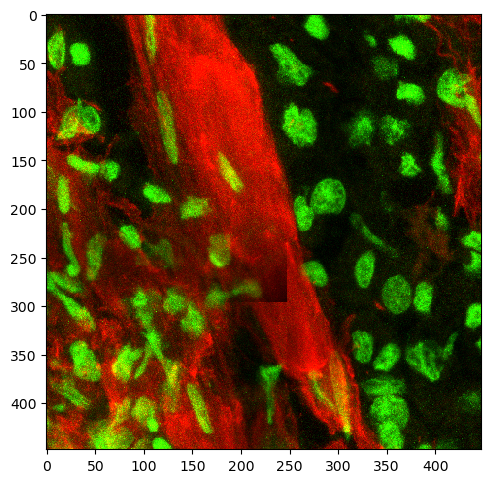

In [8]:
# Visualize a random image from the dataset
index = random.choice(range(df.shape[0]))
t = io.imread(img_dir + df.iloc[index]['Key'])
print(type(t))

plt.figure(figsize=(5,5))
io.imshow(t)

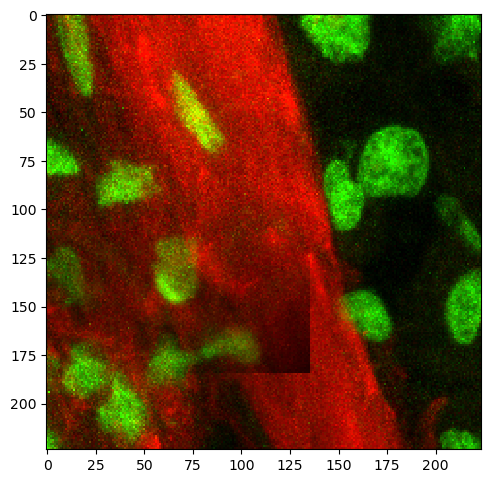

In [9]:
# Visualize the validation transform for said image
t2 = valid_transform(t)

t2 = t2.detach().cpu().numpy()
zeros = np.zeros(t2[0].shape)
plt.figure(figsize=(5,5))
io.imshow(np.stack([t2[0], t2[1], zeros], axis=2))

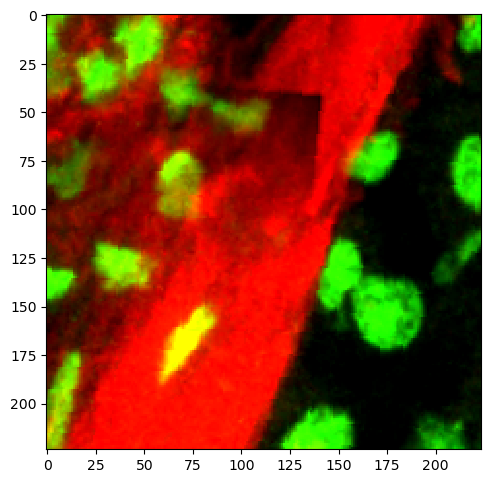

In [10]:
# Visualize a test_transform for the given image
t3 = test_transform(t)

t3 = t3.detach().cpu().numpy()
zeros = np.zeros(t3[0].shape)
plt.figure(figsize=(5,5))
io.imshow(np.stack([t3[0], t3[1], zeros], axis=2))

# Define the model

In [11]:
batch_size = 16
n_epochs = 10
learning_rate = 4e-6
weight_decay = 4e-7
# Loss function
criterion = nn.MSELoss()

In [12]:
#https://pytorch.org/vision/0.8/_modules/torchvision/models/alexnet.html
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1, dropout: float = 0.5) -> None:
        super().__init__()
        #_log_api_usage_once(self)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    

# Visualize the network

In [13]:
################################################## GradCam
class GradCamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            #print('hey')
            x = module(x)  # Forward
            #print(self.target_layer)
            if module_pos == self.target_layer:
                #print('target layer found')
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        #print('yo')
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    #print('hi')
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        #print('hi')
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = GradCamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target

        model_output.backward(retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        # Get convolution outputs
        target = conv_output.data.cpu().numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Have a look at issue #11 to check why the above is np.ones and not np.zeros
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        # ^ I am extremely unhappy with this line. Originally resizing was done in cv2 which
        # supports resizing numpy matrices with antialiasing, however,
        # when I moved the repository to PIL, this option was out of the window.
        # So, in order to use resizing with ANTIALIAS feature of PIL,
        # I briefly convert matrix to PIL image and then back.
        # If there is a more beautiful way, do not hesitate to send a PR.

        # You can also use the code below instead of the code line above, suggested by @ ptschandl
        # from scipy.ndimage.interpolation import zoom
        # cam = zoom(cam, np.array(input_image[0].shape[1:])/np.array(cam.shape))
        return cam


################################################## ScoreCam
class ScoreCamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if module_pos == self.target_layer:
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class ScoreCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = ScoreCamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 1000)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Get convolution outputs
        target = conv_output[0]
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i in range(len(target)):
            # Unsqueeze to 4D
            saliency_map = torch.unsqueeze(torch.unsqueeze(target[i, :, :],0),0)
            # Upsampling to input size
            saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
            if saliency_map.max() == saliency_map.min():
                continue
            # Scale between 0-1
            norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
            # Get the target score
            w = F.softmax(self.extractor.forward_pass(input_image*norm_saliency_map)[1],dim=1)[0][target_class]
            #print(w)
            cam += w.data.cpu().numpy() * target[i, :, :].data.cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam

################################################## Guided Backprop
class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.hook_list = []
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_list.append(self.hook_layers())

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        first_layer = list(self.model.features._modules.items())[0][1]
        return first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        for pos, module in self.model.features._modules.items():
            if isinstance(module, ReLU):
                self.hook_list.append(module.register_backward_hook(relu_backward_hook_function))
                self.hook_list.append(module.register_forward_hook(relu_forward_hook_function))

    def generate_gradients(self, input_image, target_class):
        # Forward pass
        model_output = self.model(input_image)
        # Zero gradients
        self.model.zero_grad()
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        # Backward pass
        #print('hi')
        #print(model_output.shape)
        model_output.backward(gradient=one_hot_output)
        #print('hi2')
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr
    
    def remove_all_hooks(self):
        for hook in self.hook_list:
            hook.remove()
    
################################################## Guided GradCam
def guided_grad_cam(grad_cam_mask, guided_backprop_mask):
    """
        Guided grad cam is just pointwise multiplication of cam mask and
        guided backprop mask

    Args:
        grad_cam_mask (np_arr): Class activation map mask
        guided_backprop_mask (np_arr):Guided backprop mask
    """
    cam_gb = np.multiply(grad_cam_mask, guided_backprop_mask)
    return cam_gb



In [14]:
from collections import OrderedDict
from typing import Dict, Callable
import torch

def remove_all_hooks(model: torch.nn.Module) -> None:
    for name, child in model._modules.items():
        if child is not None:
            if hasattr(child, "_forward_hooks"):
                child._forward_hooks: Dict[int, Callable] = OrderedDict()
            elif hasattr(child, "_forward_pre_hooks"):
                child._forward_pre_hooks: Dict[int, Callable] = OrderedDict()
            elif hasattr(child, "_backward_hooks"):
                child._backward_hooks: Dict[int, Callable] = OrderedDict()
            remove_all_hooks(child)

In [15]:
def visualize_sample(img_path, network):
    
    global dest


    t = io.imread(img_path)

    t3 = valid_transform(t)

    # Need to set requires_grad to true to get the gradients during backpropagation
    t3.requires_grad = True

    # Adds one dimension
    prep_img = t3[None, :]

    ##### Plotting 
    t4 = t3.detach().cpu().numpy()
    zeros = np.zeros(t4[0].shape)
    plt.subplot(241)
    io.imshow(np.stack([t4[0], zeros, t4[1]], axis=2))
    plt.title('Input Image')
    plt.grid(None)

    ############################################# Saliency Map
    score = network(t3[None])[0]
    score.backward()

    sal = t3.grad.data.abs()

    ################## Plotting
    im_new = np.stack([sal[0], sal[1], zeros.astype('float32')], axis=2)
    im_new = im_new / np.max(im_new)
    #im_new = (255*im_new).astype(np.uint8)
    plt.subplot(242)
    plt.title('Saliency Map')
    io.imshow(im_new)
    plt.grid(None)




    ############################################# GradCam
    gcv2 = GradCam(network, target_layer='3')
    # Generate cam mask
    cam = gcv2.generate_cam(prep_img, target_class=0)
    #print('Grad cam completed')

    plt.subplot(243)
    plt.title('GradCam')
    io.imshow(cam, cmap='viridis')
    plt.grid(None)
    
    '''
    ######### Save the colorbar
    c_min = np.min(cam)
    c_max = np.max(cam)
    a = np.array([[c_min,c_max]])
    plt.figure(figsize=(10, 10))
    img = plt.imshow(a, cmap="viridis")
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.1, 0.6])
    cbar = plt.colorbar(orientation="vertical", cax=cax)
    cbar.ax.tick_params(labelsize=18)
    #cbar.ax.set_ylabel('log(elasticity) (Pa)', fontsize=18)
    plt.savefig(dest + img_path.split('/')[-1][:-4] + '_gradcam_colorbar.svg',
        format = 'svg', transparent=True, bbox_inches='tight')#, dpi=1000)
    #plt.savefig(out_dir + name + "_colorbar.png")
    '''
    
    ############################################# ScoreCam
    score_cam = ScoreCam(network, target_layer='3')
    # Generate cam mask
    cam = score_cam.generate_cam(prep_img, target_class=0)

    plt.subplot(244)
    plt.title('ScoreCam')
    io.imshow(cam, cmap='viridis')
    plt.grid(None)
    
    '''
    ######### Save the colorbar
    c_min = np.min(cam)
    c_max = np.max(cam)
    a = np.array([[c_min,c_max]])
    plt.figure(figsize=(10, 10))
    img = plt.imshow(a, cmap="viridis")
    plt.gca().set_visible(False)
    cax = plt.axes([0.1, 0.2, 0.1, 0.6])
    cbar = plt.colorbar(orientation="vertical", cax=cax)
    cbar.ax.tick_params(labelsize=18)
    #cbar.ax.set_ylabel('log(elasticity) (Pa)', fontsize=18)
    plt.savefig(dest + img_path.split('/')[-1][:-4] + '_scorecam_colorbar.svg',
        format = 'svg', transparent=True, bbox_inches='tight')#, dpi=1000)
    #plt.savefig(out_dir + name + "_colorbar.png")
    '''

    
    ############################################# Guided backprop
    GBP = GuidedBackprop(network)
    # Get gradients
    guided_grads = GBP.generate_gradients(prep_img, target_class=0)
    #print('Guided backpropagation completed')

    input_image = prep_img
    target_class = 0


    model_output = GBP.model(input_image)
    # Zero gradients
    GBP.model.zero_grad()
    # Backward pass
    model_output.backward()
    # Convert Pytorch variable to numpy array
    # [0] to get rid of the first channel (1,3,224,224)
    gradients_as_arr = GBP.gradients.data.cpu().numpy()[0]

    # Convert to grayscale
    grayscale_guided_grads = convert_to_grayscale(guided_grads)
    # Positive and negative saliency maps
    pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)


    # Remove the added hooks from the network
    GBP.remove_all_hooks()

    plt.subplot(245)
    plt.title('Guided BackProp')
    io.imshow(grayscale_guided_grads[0])
    plt.grid(None)

    plt.subplot(246)
    plt.title('Positive Saliency')
    io.imshow(pos_sal[0])
    plt.grid(None)

    plt.subplot(247)
    plt.title('Negative Saliency')
    io.imshow(neg_sal[0])
    plt.grid(None)


    ############################################# Guided Grad cam
    cam_gb = guided_grad_cam(cam, guided_grads)
    grayscale_cam_gb = convert_to_grayscale(cam_gb)

    plt.subplot(248)
    plt.title('Guided GradCam')
    io.imshow(grayscale_cam_gb[0])
    plt.grid(None)

    fig2.savefig(dest + img_path.split('/')[-1][:-4] + '_VIS.png',
                 facecolor='white', edgecolor='none')
    
    fig2.savefig(dest + img_path.split('/')[-1][:-4] + '_VIS.svg',
                 format='svg', facecolor='white', edgecolor='none')
    
    return

# Train the Models

In [16]:
############### Initialize lists for tracking important parameters
sample_list = []

# Log-transformed data
val_log_mse = []
pearsonr_val_log_r = []
pearsonr_val_log_p = []

train_log_mse = []
pearsonr_train_log_r = []
pearsonr_train_log_p = []

# Non-transformed data
val_real_mse = []
pearsonr_val_real_r = []
pearsonr_val_real_p = []

train_real_mse = []
pearsonr_train_real_r = []
pearsonr_train_real_p = []

In [17]:
# 5 different sets of transformation options used for training 
brightness_options = [(.9,1.1), (.8,1.2), (.5,1.5), (.8,1.2), (.9,1.1)]
contrast_options = [(.5,1.5), (.8,1.2), (.5,1.5), (.5,1.5), (.75,1.5)]
sharpness_options = [(1.5,.67), (1.5,.67), (1.5,.67), (1,1), (1,1)]

Iteration is 0
Length of training df is 793
Length of validation df is 207
['20-030_region1' 'B1974_region2' 'B2066-Q6' 'B2086_region2'
 'B2091_region2' 'B2128-Q4']
Num of parameters is 57007937


  0%|          | 0/10 [00:00<?, ?it/s]

0.01714010551748537
Epoch time is 19.891590118408203
0.05432382995049598
Epoch time is 20.93645715713501
0.11666154380988425
Epoch time is 21.345008373260498
0.17985622745098756
Epoch time is 21.13447093963623
0.25679507252135064
Epoch time is 21.429373025894165
0.3183342053658795
Epoch time is 20.709999322891235
0.36611909259953146
Epoch time is 20.40543794631958
0.40481672664452073
Epoch time is 21.695948839187622
0.41648744983330477
Epoch time is 22.27679181098938
0.4310277585102573
Epoch time is 21.3131685256958
Training time is 211.16295909881592
mse is 0.2503879809981027
(0.4310277585102573, 8.974970162992827e-11)
                 % error
Sample                  
B1974_region2   0.434124
B2128-Q4        0.258171
20-030_region1  0.221564
B2066-Q6        0.210505
B2086_region2   0.208480
B2091_region2   0.139249
Saving worst validation fits
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B1974_region2_15.tif


/home/user/anaconda3/envs/STIFMaps/lib/python3.7/site-packages/ipykernel_launcher.py:83: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
/home/user/anaconda3/envs/STIFMaps/lib/python3.7/site-packages/ipykernel_launcher.py:168: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
/home/user/anaconda3/envs/STIFMaps/lib/python3.7/site-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B1974_region2_10.tif
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B1974_region2_29.tif
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B1974_region2_36.tif
Saving best validation fits
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B2091_region2_11.tif
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B2066-Q6_51.tif
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B2091_region2_19.tif
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B2128-Q4_18.tif
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/20-037_region1_11.tif
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B2128-Q6_2.tif
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/B2251_region1_7.tif
Saving /media/user/Extreme SSD/STIFMap_publication_data/squares/BRPC-12-107_region2_0.tif
Saving /media/user/Extreme SSD/STIFMap_publicati

  0%|          | 0/10 [00:00<?, ?it/s]

-0.11753155257636852
Epoch time is 20.749840021133423
-0.08996982928246641
Epoch time is 20.811378717422485
-0.04741254584648931
Epoch time is 20.248632192611694
0.0020786354619323835
Epoch time is 20.688544750213623
0.056564903715817405
Epoch time is 20.898054599761963
0.10776790442678061
Epoch time is 21.277523279190063
0.15118348695179543
Epoch time is 21.313619136810303
0.18388175762448777
Epoch time is 20.85425090789795


KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

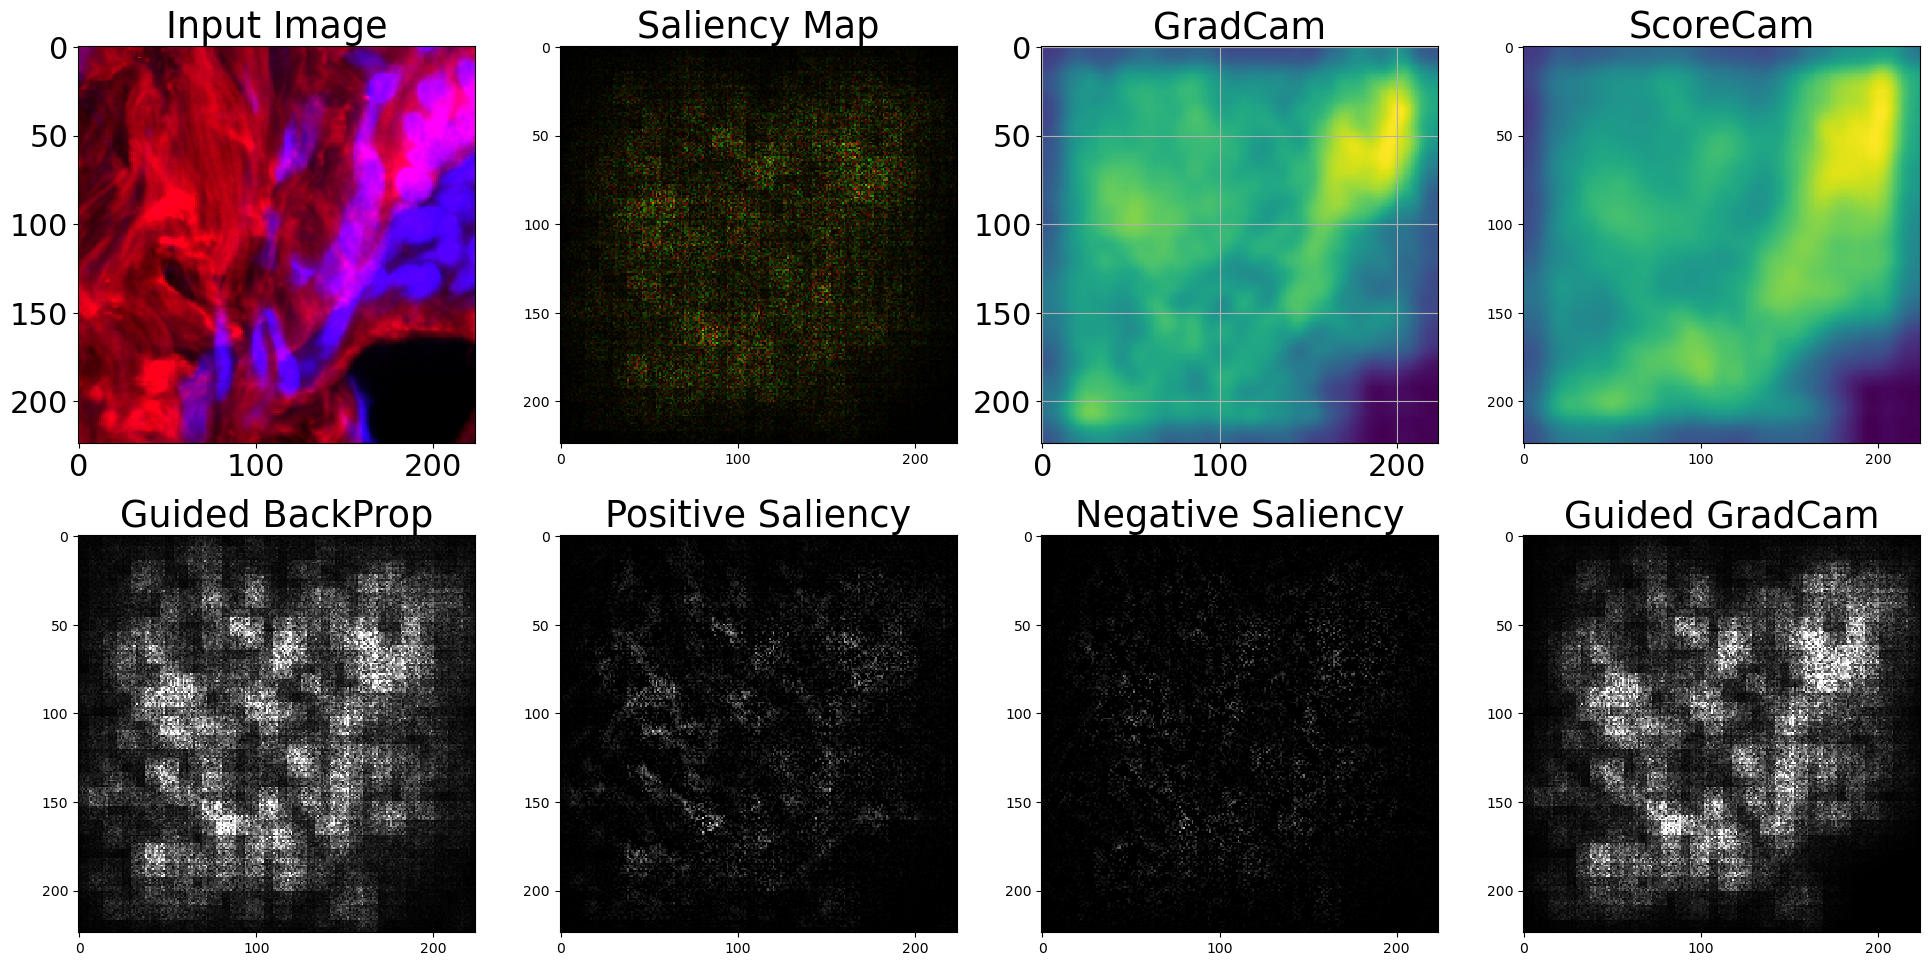

In [18]:
fig = plt.figure(figsize=(10,10))
fig2, axs = plt.subplots(2, 4, figsize=(20,10))

iteration = 0

# Train each of the 5 models 5 times
for j in range(5):
    for i in range(5):

        print('Iteration is ' + str(iteration))

        brightness_range = brightness_options[i]
        contrast_range = contrast_options[i]
        sharpness_range = sharpness_options[i]


        train_transform = transforms.Compose(
            [transforms.ToPILImage(),
            # (optional) Resize to account for different magnification (Data is 0.2405 um/pixel)
            #transforms.Resize(size=(248,248)),
            #transforms.Resize(size=(448,448)),
            
            # Transformations
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=360),
            transforms.CenterCrop(side_length_crop),
            transforms.ColorJitter(brightness=brightness_range, contrast=contrast_range),
            transforms.RandomAdjustSharpness(sharpness_range[0], p=.5),
            transforms.RandomAdjustSharpness(sharpness_range[1], p=.5),
            #transforms.GaussianBlur(kernel_size=(5,9), sigma=(.9,1.1)),
            transforms.ToTensor(),
            #transforms.Lambda(lambda x: x[0:2]) # Remove the blank channel
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])





        ################################################## Split the dataset into validation and training
        from torch.utils.data.sampler import SubsetRandomSampler

        validation_split = 0.2

        # Get a list of unique samples and randomize them
        samples = df['Sample'].unique()
        np.random.shuffle(samples)

        # Split the samples into a training and validation set
        train_samples = samples[round(len(samples)*validation_split):]
        val_samples = samples[:round(len(samples)*validation_split)]

        ########## Split the dataframe into train and validation
        df_val = df.loc[df['Sample'].isin(val_samples)]
        df_train = df.loc[df['Sample'].isin(train_samples)]

        # Reset the index
        df_train = df_train.reset_index(drop=True)
        df_val = df_val.reset_index(drop=True)

        print('Length of training df is ' + str(df_train.shape[0]))
        print('Length of validation df is ' + str(df_val.shape[0]))
        print(df_val['Sample'].unique())





        ######### Specify the training and validation datasets
        training_set = CustomImageDataset(
            df = df_train,
            img_dir = img_dir,
            transform = train_transform
        )
        validation_set = CustomImageDataset(
            df = df_val,
            img_dir = img_dir,
            transform = valid_transform
        )


        trainloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
        validloader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)









        #################################################################### Initialize the network
        network = AlexNet()

        print('Num of parameters is ' +str(sum(p.numel() for p in network.parameters())))
        #print([p.numel() for p in network.parameters()])




        ######################################################### TRAIN THE NETWORK
        then = time.time()

        network_training_loss = []
        network_training_pval = []
        network_training_rval = []
        network_training_1_to_1_r2 = []
        network_valid_loss = []
        network_valid_pval = []
        network_valid_rval = []
        network_valid_1_to_1_r2 = []


        network.to(device) 

        #optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        optimizer = optim.Adam(network.parameters(), lr=learning_rate, weight_decay=weight_decay)

        # train for n_epochs 
        for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times
            running_loss = 0.0

            then2 = time.time()

            # NEED TO SWITCH BETWEEN EVALUATION AND TRAINING MODE FOR THE DROPOUT LAYERS TO WORK AS INTENDED
            network.train()

            train_labels = []
            train_outputs = []
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # labels provides the ground truth answers
                inputs, labels = data[0].to(device), data[1].to(device)  
                #print('TRAINING')
                #print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = network(inputs)
                outputs = torch.reshape(outputs, (-1,))

                loss = criterion(outputs, labels.float())
                loss.backward()
                optimizer.step()

                # loss accumulation 
                running_loss += loss.item()



                # Getting correlation coefficients
                labels = list(labels.cpu().numpy())
                outputs = list(outputs.detach().cpu().numpy().flatten())

                train_labels = train_labels + labels
                train_outputs = train_outputs + outputs

            r_val, p_val = pearsonr(train_labels, train_outputs)

            network_training_loss.append(running_loss/(i+1))
            network_training_pval.append(p_val)
            network_training_rval.append(r_val)

            # Calculate the coefficient of determination about the 1:1 line
            x = train_labels
            y = train_outputs
            y_bar = np.mean(y)
            SS_res = sum([(y[i] - x[i])**2 for i in range(len(y))])
            SS_tot = sum([(y[i] - y_bar)**2 for i in range(len(y))])
            r2 = 1 - SS_res/SS_tot
            #print(r2)
            network_training_1_to_1_r2.append(r2)

            ########################## Check the validation dataset
            # NEED TO SWITCH BETWEEN EVALUATION AND TRAINING MODE FOR THE DROPOUT LAYERS TO WORK AS INTENDED
            network.eval()

            valid_loss = 0.0

            val_labels = []
            val_outputs = []
            for i, data in enumerate(validloader, 0):
            #for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # labels provides the ground truth answers
                inputs, labels = data[0].to(device), data[1].to(device)          
                #print('VALIDATION')
                #print(labels)

                # forward + backward + optimize
                outputs = network(inputs)
                outputs = torch.reshape(outputs, (-1,))

                loss = criterion(outputs, labels)
                valid_loss += loss.item()

                # Getting correlation coefficients
                labels = list(labels.cpu().numpy())
                outputs = list(outputs.detach().cpu().numpy().flatten())

                val_labels = val_labels + labels
                val_outputs = val_outputs + outputs

            r_val, p_val = pearsonr(val_labels, val_outputs)

            network_valid_loss.append(valid_loss/(i+1))
            network_valid_pval.append(p_val)
            network_valid_rval.append(r_val)
            print(r_val)

            # Calculate the coefficient of determination about the 1:1 line
            x = val_labels
            y = val_outputs
            y_bar = np.mean(y)
            SS_res = sum([(y[i] - x[i])**2 for i in range(len(y))])
            SS_tot = sum([(y[i] - y_bar)**2 for i in range(len(y))])
            r2 = 1 - SS_res/SS_tot
            #print(r2)
            network_valid_1_to_1_r2.append(r2)


            now2 = time.time()
            print('Epoch time is ' + str(now2-then2))

        now = time.time()

        print('Training time is ' + str(now-then))





        ################################# Save output plots
        plt.figure(fig)

        plt.rcParams.update({'font.size': 22})
        name = 'iteration_' + str(iteration) + '_'

        ####### Loss
        plt.scatter(list(range(len(network_training_loss))), network_training_loss, label='Training')
        plt.scatter(list(range(len(network_valid_loss))), network_valid_loss, label='Validation')
        plt.legend(fontsize=22)
        plt.xlabel('Epoch', fontsize=26)
        plt.ylabel('Loss', fontsize=26)
        fig.savefig(out_dir + name + 'loss.TIF',  bbox_inches='tight')
        fig.clf()

        ####### pval
        plt.scatter(list(range(len(network_training_pval))), -np.log10(network_training_pval), label='Training')
        plt.scatter(list(range(len(network_valid_pval))), -np.log10(network_valid_pval), label='Validation')
        plt.legend(fontsize=22)
        plt.xlabel('Epoch', fontsize=26)
        plt.ylabel('-log10(p-value)', fontsize=26)
        fig.savefig(out_dir + name + 'pval.TIF', bbox_inches='tight')
        fig.clf()

        ####### rval
        plt.scatter(list(range(len(network_training_rval))), network_training_rval, label='Training')
        plt.scatter(list(range(len(network_valid_rval))), network_valid_rval, label='Validation')
        plt.legend(fontsize=22)
        plt.xlabel('Epoch', fontsize=26)
        plt.ylabel('Correlation (r)', fontsize=26)
        fig.savefig(out_dir + name + 'rval.TIF', bbox_inches='tight')
        fig.clf()

        ####### scatter
        val_labels = np.array(val_labels)
        val_outputs = np.array(val_outputs)

        print('mse is ' + str(((val_labels - val_outputs)**2).mean()))
        print(pearsonr(val_labels,val_outputs))

        plt.scatter(val_labels, val_outputs, s=5)
        plt.gca().set_aspect('equal')
        plt.xlabel('log(actual stiffness) (Pa)', fontsize=22)
        plt.ylabel('log(predicted stiffness) (Pa)', fontsize=22)
        fig.savefig(out_dir + name + 'scatter.TIF',  bbox_inches='tight')
        fig.clf()


        ####### dataframe of QC metrics 
        df_out = pd.DataFrame({'network_training_loss':network_training_loss, 
            'network_training_pval':network_training_pval,
            'network_training_rval':network_training_rval,
            'network_training_1_to_1_r2':network_training_1_to_1_r2,
            'network_valid_loss':network_valid_loss,
            'network_valid_pval':network_valid_pval,
            'network_valid_rval':network_valid_rval,
            'network_valid_1_to_1_r2':network_valid_1_to_1_r2})
        df_out.to_csv(out_dir + name + 'TRAINING.csv')

        ####### dataframe of predicted vs actual values
        df_val['Predicted Stiffness'] = val_outputs
        df_val['% error'] = abs(df_val['Stiffness'] - df_val['Predicted Stiffness'])**2 # / df_val['Stiffness'] # 
        df_val = df_val.sort_values('% error', ascending=False)
        df_out2 = df_val[['Sample','Forceplot','Stiffness','Predicted Stiffness','% error']]
        df_out2.to_csv(out_dir + name + 'PREDICTIONS.csv')

        ####### dataframe of error by sample
        #key_list = df_val.sort_values('% error', ascending=False).head(10)['Key'].tolist()
        df_out3 = df_val.groupby('Sample').mean()['% error'].to_frame()
        df_out3 = df_out3.sort_values('% error', ascending=False)
        df_out3.to_csv(out_dir + name + 'ERRORS.csv')
        print(df_out3)



        ############################# Write out the parameters
        with open(out_dir + 'iteration_' + str(iteration) + '_log.txt', 'a') as f:
            f.write('brightness_range:' + str(brightness_range) + '\n')
            f.write('contrast_range:' + str(contrast_range) + '\n')
            f.write('sharpness_range:' + str(sharpness_range) + '\n')

        
        #############################
        #############################
        ###################################################### Visualizations
        ############################# Save saliency maps for the 5 best and 5 worst samples
        ############################# for the training and validation datasets

        plt.figure(fig2)
        network.to("cpu")

        ############################# Plot the top 10 best and worst predicted plots
        # Make directories
        if not os.path.isdir(out_dir + 'iteration_' + str(iteration)):
            os.makedirs(out_dir + 'iteration_' + str(iteration))
            os.makedirs(out_dir + 'iteration_' + str(iteration) + '/training/')
            os.makedirs(out_dir + 'iteration_' + str(iteration) + '/training/worst_fits/')
            os.makedirs(out_dir + 'iteration_' + str(iteration) + '/training/best_fits/')
            os.makedirs(out_dir + 'iteration_' + str(iteration) + '/validation/')
            os.makedirs(out_dir + 'iteration_' + str(iteration) + '/validation/worst_fits/')
            os.makedirs(out_dir + 'iteration_' + str(iteration) + '/validation/best_fits/')

        ###################### Validation set
        # First the worst fits
        dest = out_dir + 'iteration_' + str(iteration) + '/validation/worst_fits/'

        key_list = df_val.head(4)['Key'].tolist()
        print('Saving worst validation fits')
        for key in key_list:
            ####### Visualizations
            img_path = os.path.join(img_dir, key)
            print('Saving ' + img_path)
            visualize_sample(img_path, network)




        # Then the best fits
        dest = out_dir + 'iteration_' + str(iteration) + '/validation/best_fits/'

        key_list = df_val.tail(4)['Key'].tolist()
        print('Saving best validation fits')
        for key in key_list:
            ####### Visualizations
            img_path = os.path.join(img_dir, key)
            print('Saving ' + img_path)
            visualize_sample(img_path, network)




        ###################### Training set
        train_predictions = pd.DataFrame({'Ground Truth':train_labels,
                                          'Predicted Stiffness':train_outputs})

        df_train = pd.merge(df_train, train_predictions, left_on='Stiffness', right_on='Ground Truth')

        df_train['% error'] = abs(df_train['Stiffness'] - df_train['Predicted Stiffness'])**2 # / df_train['Stiffness'] # 
        df_train = df_train.sort_values('% error', ascending=False)


        # First the worst fits
        dest = out_dir + 'iteration_' + str(iteration) + '/training/worst_fits/'

        key_list = df_train.head(4)['Key'].tolist()
        for key in key_list:
            ####### Visualizations
            img_path = os.path.join(img_dir, key)
            print('Saving ' + img_path)
            visualize_sample(img_path, network)




        # Then the best fits
        dest = out_dir + 'iteration_' + str(iteration) + '/training/best_fits/'

        key_list = df_train.tail(4)['Key'].tolist()
        for key in key_list:
            ####### Visualizations
            img_path = os.path.join(img_dir, key)
            print('Saving ' + img_path)
            visualize_sample(img_path, network)

        

        # Save the model
        #torch.save(network.state_dict(), '/media/user/Bainer_DeepStore_1/Connor/autoAFM_data/neural_net/saved_models/v7_broadnet_iteration_' + str(iteration) + '.pt')

        iteration += 1